# Integrating external data from a CSV <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)

## Background
It is often useful to combine external data (e.g. from a CSV or other dataset) with data loaded from Digital Earth Australia. 
For example, we may want to combine data from a tide or river guage with satellite data to determine water levels at the exact moment each satellite observation was made. 
This can allow us to manipulate and extract satellite data and obtain additional insights using data from our external source.

## Description
This example notebook loads in a time series of external tide modelling data from a CSV, and combines it with satellite data loaded from Digital Earth Australia.
This workflow could be applied to any external time series dataset (e.g. river guages, tide guagues, rainfall measurements etc). 
The notebook demonstrates how to:

1. Load a time series of Landsat 8 data
2. Load in external time series data from a CSV
3. Convert this data to an `xarray.Dataset` and link it to each satellite observation by interpolating values at each satellite timestep
4. Add this new data as a variable in our satellite dataset, and use this to filter satellite imagery to high and low tide imagery
5. Demonstrate how to swap dimensions between `time` and the new `tide_height` variable

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

import datacube
import pandas as pd
import matplotlib.pyplot as plt

pd.plotting.register_matplotlib_converters()


### Connect to the datacube


In [2]:
dc = datacube.Datacube(app='Integrating_external_data')


## Loading satellite data
First we load in a year of Landsat 8 data. 
We will use Moreton Bay in Queensland for this demonstration, as we have a CSV of tide height data for this location that we wish to combine with satellite data.
We load a single band `nbart_nir` which clearly differentiates between water (low values) and land (higher values). 
This will let us verify that we can use external tide data to identify low and high tide satellite observations.

In [3]:
# Set up a location for the analysis
query = {
    'x': (153.38, 153.42),
    'y': (-27.63, -27.67),
    'time': ('2015-01-01', '2015-12-31'),
    'measurements': ['nbart_nir'],
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30)
}

# Load Landsat 8 data
ds = dc.load(product='ga_ls8c_ard_3', group_by='solar_day', **query)

print(ds)


<xarray.Dataset>
Dimensions:    (time: 23, x: 154, y: 170)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-11T23:42:10.081625 ... 2015-12-29T23:42:14.365276
  * y          (y) float64 -3.171e+06 -3.172e+06 ... -3.177e+06 -3.177e+06
  * x          (x) float64 2.074e+06 2.074e+06 2.074e+06 ... 2.078e+06 2.078e+06
Data variables:
    nbart_nir  (time, y, x) int16 6511 6509 6451 6434 ... 1976 1967 2150 2254
Attributes:
    crs:      EPSG:3577


## Integrating external data
### Load in a CSV of external data with timestamps

In the code below, we aim to take a CSV file of external data (in this case, half-hourly tide heights for a location in Moreton Bay, Queensland for a five year period between 2014 and 2018 generated using the [OTPS TPXO8 tidal model](http://volkov.oce.orst.edu/tides/tpxo8_atlas.html)), and link this data back to our satellite data timeseries. 

We can load the existing tide height data using the `pandas` module which we imported earlier. The data has a column of `time` values, which we will set as the index column (roughly equivelent to a `dimension` in `xarray`). 

In [4]:
tide_data = pd.read_csv('../Supplementary_data/Integrating_external_data/moretonbay_-27.55_153.35_2014-2018_tides.csv', 
                          parse_dates=['time'], 
                          index_col='time')

tide_data.head()


,tide_height
time,
2014-01-01 00:00:00,1.179
2014-01-01 00:30:00,1.012
2014-01-01 01:00:00,0.805
2014-01-01 01:30:00,0.569
2014-01-01 02:00:00,0.316


### Link external data to satellite data

Now that we have the tide height data, we need to estimate the tide height for each of our satellite images. 
We can do this by interpolating between the data points we do have (hourly measurements) to get an estimated tide height for the exact moment each satellite image was taken.

The code below generates an `xarray.Dataset` with the same number of timesteps as the original satellite data.
The dataset has a single variable `tide_height` that gives the estimated tide hight for each observation:

In [5]:
# First, we convert the data to an xarray dataset so we can analyse it 
# in the same way as oursatellite data
tide_data_xr = tide_data.to_xarray()

# We want to convert our hourly tide heights to estimates of exactly how
# high the tide was at the time that each satellite image was taken. To 
# do this, we can use `.interp` to 'interpolate' a tide height for each
# satellite timestamp:
satellite_tideheights = tide_data_xr.interp(time=ds.time)

# Print the output xarray object
print(satellite_tideheights)


<xarray.Dataset>
Dimensions:      (time: 23)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-11T23:42:10.081625 ... 2015-12-29T23:42:14.365276
Data variables:
    tide_height  (time) float64 0.02013 -0.2608 -0.2658 ... 1.105 1.007 0.4098


Now we have our tide heights in `xarray` format that matches our satellite data, we can add this back into our satellite dataset as a new variable:

In [6]:
# We then want to put these values back into the Landsat dataset so 
# that each image has an estimated tide height:
ds['tide_height'] = satellite_tideheights.tide_height


We can now plot tide heights for our satellite data:

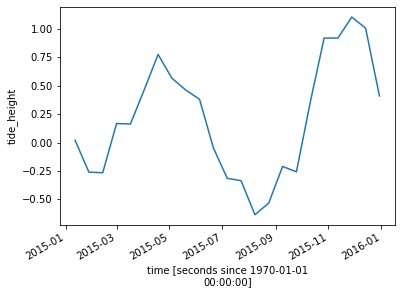

In [7]:
# Plot the resulting tide heights for each Landsat image:
ds.tide_height.plot()
plt.show()


### Filtering by external data
Now that we have a new variable `tide_height` in our dataset, we can use `xarray` indexing methods to manipulate our data using tide heights (e.g. filter by tide to select low or high tide images):

In [8]:
# Select a subset of low tide images (tide less than -0.6 m)
low_tide_ds = ds.sel(time = ds.tide_height < -0.60)

# Select a subset of high tide images (tide greater than 0.9 m)
high_tide_ds = ds.sel(time = ds.tide_height > 0.9)


We can plot an image from these subsets to verify that the satellite images were observed at low tide:

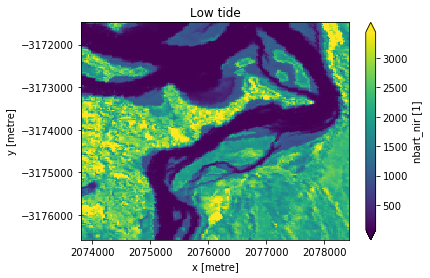

In [9]:
low_tide_ds.isel(time=0).nbart_nir.plot(robust=True)
plt.title("Low tide")
plt.show()


And at high tide. Note that many tidal flat areas in the image above (blue-green) now appear inundated by water (dark blue/purple):

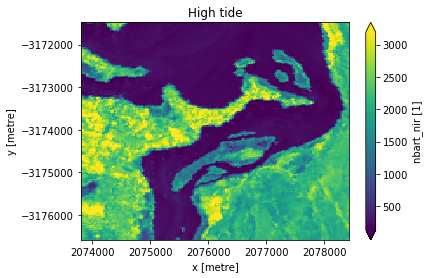

In [10]:
high_tide_ds.isel(time=0).nbart_nir.plot(robust=True)
plt.title("High tide")
plt.show()


### Swapping dimensions based on external data
By default, `xarray` uses `time` as one of the main dimensions in the dataset (in addition to `x` and `y`). Now that we have a new `tide_height` variable, we can change this to be an actual dimension in the dataset in place of `time`. This enables additional more advanced operations, such as calculating rolling statistics or aggregating by `tide_heights`.

In the example below, you can see that the dataset now has three dimensions (`tide_height`, `x` and `y`). The dimension `time` is no longer a dimension in the dataset.

In [11]:
print(ds.swap_dims({'time': 'tide_height'}))


<xarray.Dataset>
Dimensions:      (tide_height: 23, x: 154, y: 170)
Coordinates:
    time         (tide_height) datetime64[ns] 2015-01-11T23:42:10.081625 ... 2015-12-29T23:42:14.365276
  * y            (y) float64 -3.171e+06 -3.172e+06 ... -3.177e+06 -3.177e+06
  * x            (x) float64 2.074e+06 2.074e+06 ... 2.078e+06 2.078e+06
  * tide_height  (tide_height) float64 0.02013 -0.2608 -0.2658 ... 1.007 0.4098
Data variables:
    nbart_nir    (tide_height, y, x) int16 6511 6509 6451 ... 1967 2150 2254
Attributes:
    crs:      EPSG:3577


---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2019

**Compatible datacube version:** 

In [12]:
print(datacube.__version__)

1.7


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)